# Bildklassifizierung auf Basis von Feed-Forward Neural Network Ensembles

Dieses Jupiter Notebook untersucht die Bildklassifikation durch Feed-Forward Neural Networks mit Ensembles auf Basis des Fashion-MNIST-Datensatzes. Durch den Einsatz von mehreren stimmberechtigten Modellen wird für jede Klasse ein Ensemble bestehend aus zehn Modellen erstellt.
Dabei entsteht ein Sicherheitsmaß, welches Aussagen über die Klassifikationssicherheit treffen kann.

Im folgenden werden die nötigen Python Bibliotheken importiert.

Diese müssen installiert werden:
- numpy https://numpy.org/install/
- scipy https://scipy.org/install/
- matplotlib https://matplotlib.org/stable/install/index.html



In [1]:
import numpy
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline

# 
Die Klasse des neuronalen Netzwerks wird definiert. Diese Klasse enthält Methoden zum Initialisieren, Trainieren und Abfragen des neuronalen Netzwerks.

In [3]:
class neuralNetwork:

    # Initialisierung des neuronalen Netzwerks
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # Anzahl der Nodes in jeder Input-, hidden und output layer festlegen
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # Gewichtsmatrizen, wih und who
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # Lernrate
        self.lr = learningrate

        # Aktivierungsfunktion ist die Sigmoid-Funktion
        self.activation_function = lambda x: scipy.special.expit(x)

        pass

    # Trainieren des neuronalen Netzwerks
    def train(self, inputs_list, targets_list):
        # Inputs in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # Signale in dem Hidden Layer berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in dem endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer  hervorgehen
        final_outputs = self.activation_function(final_inputs)

        # Fehler in dem Output Layer ist (Ziel - Ist)
        output_errors = targets - final_outputs
        # Fehler in dem Hidden Layer ist der output_errors, aufgeteilt nach Gewichten, neu kombiniert an den Hidden Nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # Gewichte für die Verbindungen zwischen den hidden und den Output Layers aktualisieren
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # Gewichte für die Verbindungen zwischen den Input- und den Hidden Layern aktualisieren
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

        pass

    # Abfragen des neuronalen Netzwerks
    def query(self, inputs_list):
        # Input List in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T

        # Signale in die Hidden Layern berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in den endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer hervorgehen
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

# 
Die Anzahl der Input-, Hidden- und Output-Nodes wird festgelegt. Die Lernrate wird auf 0,05 und die Epochen auf 10 gesetzt. Anschließend wird eine Instanz des neuronalen Netzwerks erstellt.

In [4]:
input_nodes = 784
hidden_nodes = 15
output_nodes = 1
epochs = 10

learning_rate = 0.05

n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

#
Der Fashion-MNIST-Trainingsdatensatz wird eingelesen.

In [5]:
with open("./data/fashion-mnist_train.csv", 'r') as training_data_file:
    training_data_list = training_data_file.readlines()[1:]

#
Es werden zehn Ensembles erstellt, die jeweils zehn Modelle enthalten.


In [6]:
ensembles = []
for _ in range(10):
    ensemble = []
    for i in range(10):
        ensemble.append(neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate))
    ensembles.append(ensemble)

#
Die Modelle in den Ensembles werden trainiert. Es wird durch die Trainingsdaten iteriert und die Gewichte der Modelle werden angepasst.

In [7]:
for ensemble in ensembles:
    for i in range(10):
        for e in range(epochs):
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
                target = numpy.array([0.99 if int(all_values[0]) == i else 0.01])
                ensemble[i].train(inputs, target)

# 
Der Fashion-MNIST-Testdatensatz wird eingelesen.

In [8]:
with open("./data/fashion-mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()[1:]


# 
Die Vorhersagen der Modelle in den Ensembles werden gesammelt und die Genauigkeit der Klassifikation wird berechnet.


In [9]:
scorecard = []

# Go through all the records in the test data set
for record in test_data_list:
    all_values = record.split(',')
        
    # Correct answer is first value
    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Get predictions from all models in all ensembles
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        # Get the most common prediction
        prediction = max(set(ensemble_predictions), key=ensemble_predictions.count)
        # Calculate confidence (number of votes for the prediction / total votes)
        confidence = ensemble_predictions.count(prediction) / len(ensemble_predictions)
        # Append 1 to scorecard for correct prediction, 0 for incorrect
        scorecard.append(1 if prediction == correct_label else 0)
    else:
        # Handle the case when no predictions were made
        scorecard.append(0)  # Count as incorrect prediction

# Calculate the performance score
score = sum(scorecard) / len(scorecard)
print(f'Performance = {score}')

Performance = 0.8757


#
### Die Verteilung der Stimmen in den Test- und Trainingsdaten wird visualisiert und die durchschnittliche Anzahl der Stimmen in den Trainings- und Testdaten wird berechnet.

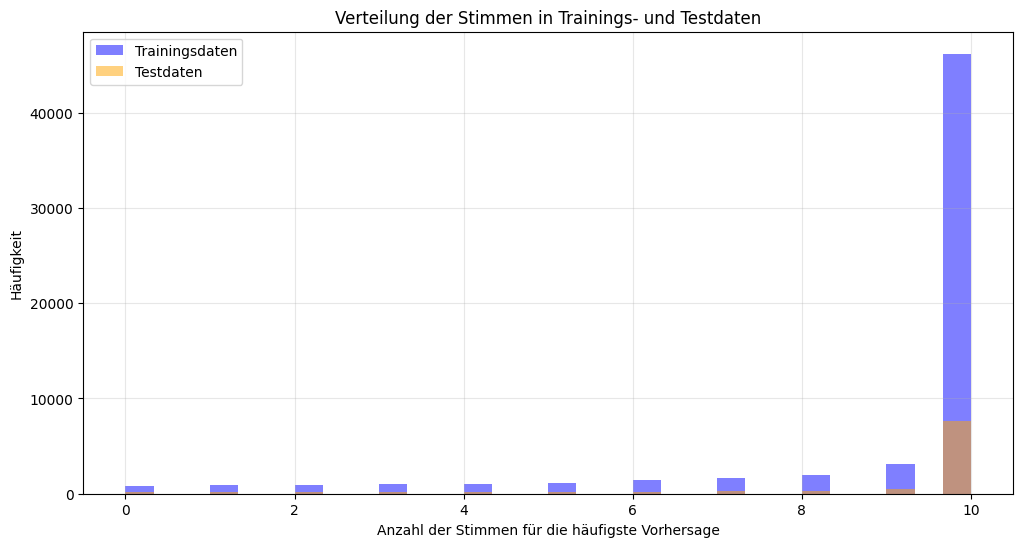

Durchschnittliche Stimmen in Trainingsdaten: 9.01
Durchschnittliche Stimmen in Testdaten: 8.98


In [10]:
train_vote_counts = []
test_vote_counts = []

for record in training_data_list:
    all_values = record.split(',')

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Stimmen von allen Modellen in allen Ensembles sammeln
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        train_vote_counts.append(votes)
    else:
        train_vote_counts.append(0)  # Null Stimmen hinzufügen, wenn keine Vorhersagen gemacht wurden

for record in test_data_list:
    all_values = record.split(',')

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Stimmen von allen Modellen in allen Ensembles sammeln
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        test_vote_counts.append(votes)
    else:
        test_vote_counts.append(0)  # Null Stimmen hinzufügen, wenn keine Vorhersagen gemacht wurden

# Verteilung der Stimmen visualisieren
plt.figure(figsize=(12, 6))
plt.hist(train_vote_counts, bins=30, alpha=0.5, label='Trainingsdaten', color='blue')
plt.hist(test_vote_counts, bins=30, alpha=0.5, label='Testdaten', color='orange')
plt.xlabel('Anzahl der Stimmen für die häufigste Vorhersage')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen in Trainings- und Testdaten')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen in Trainingsdaten: {numpy.mean(train_vote_counts):.2f}')
print(f'Durchschnittliche Stimmen in Testdaten: {numpy.mean(test_vote_counts):.2f}')


#
### Die Verteilung der Stimmen in den Testdaten wird für jede Klasse visualisiert und die durchschnittliche Anzahl der korrekten und falschen Stimmen wird für jede Klasse berechnet.
# 
Visualisierung der Stimmenverteilung für Klasse 0 (korrekte vs. falsche Klassifikationen)

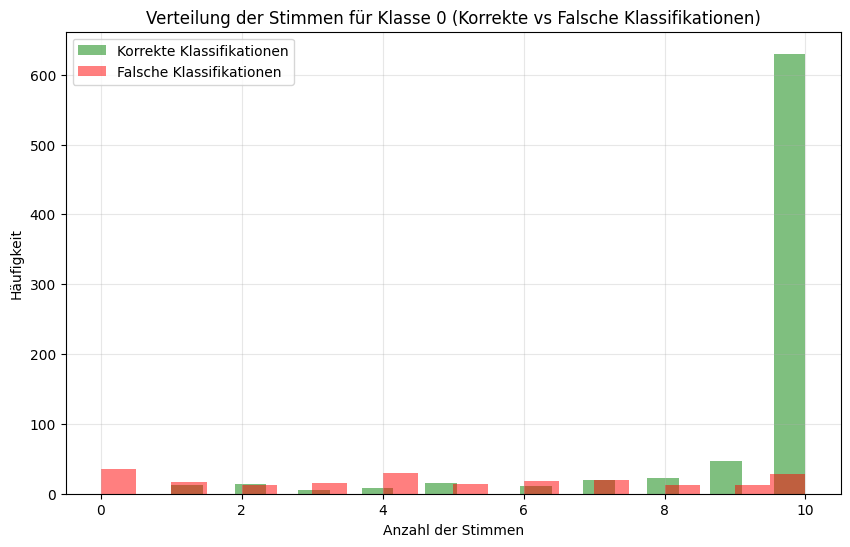

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.26
Durchschnittliche Stimmen für falsche Klassifikationen: 4.71


In [11]:
# Stimmen für Klasse 0 sammeln
correct_votes_0 = []
incorrect_votes_0 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])
    
    # Nur Klasse 0 berücksichtigen
    if correct_label == 0:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_0.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_0.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_0, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_0, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 0 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_0):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_0):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 1 (korrekte vs. falsche Klassifikationen)

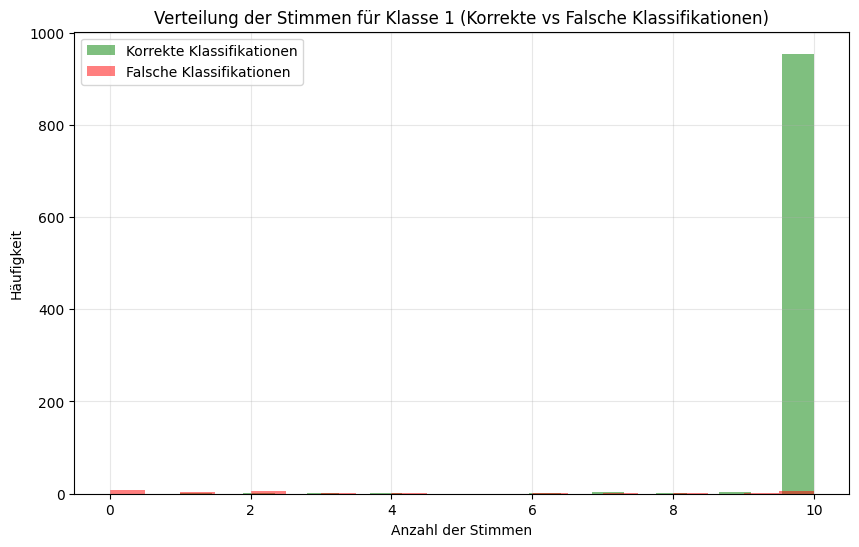

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.93
Durchschnittliche Stimmen für falsche Klassifikationen: 4.10


In [12]:
# Stimmen für Klasse 1 sammeln
correct_votes = []
incorrect_votes = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])
    
    # Nur Klasse 1 berücksichtigen
    if correct_label == 1:
        if score == 1:  # Korrekte Klassifikation
            correct_votes.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 1 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 2 (korrekte vs. falsche Klassifikationen)

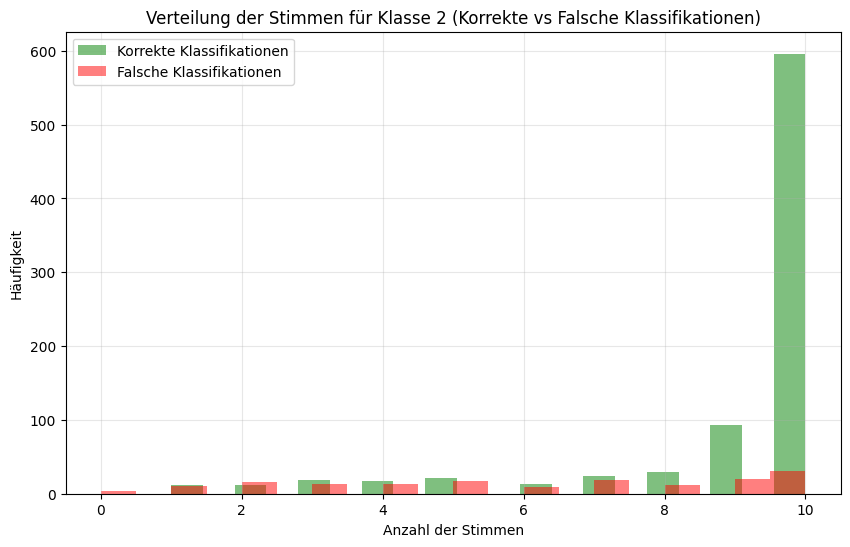

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.03
Durchschnittliche Stimmen für falsche Klassifikationen: 6.04


In [13]:
# Stimmen für Klasse 2 sammeln
correct_votes_2 = []
incorrect_votes_2 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])
    
    # Nur Klasse 2 berücksichtigen
    if correct_label == 2:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_2.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_2.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_2, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_2, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 2 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_2):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_2):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 3 (korrekte vs. falsche Klassifikationen)

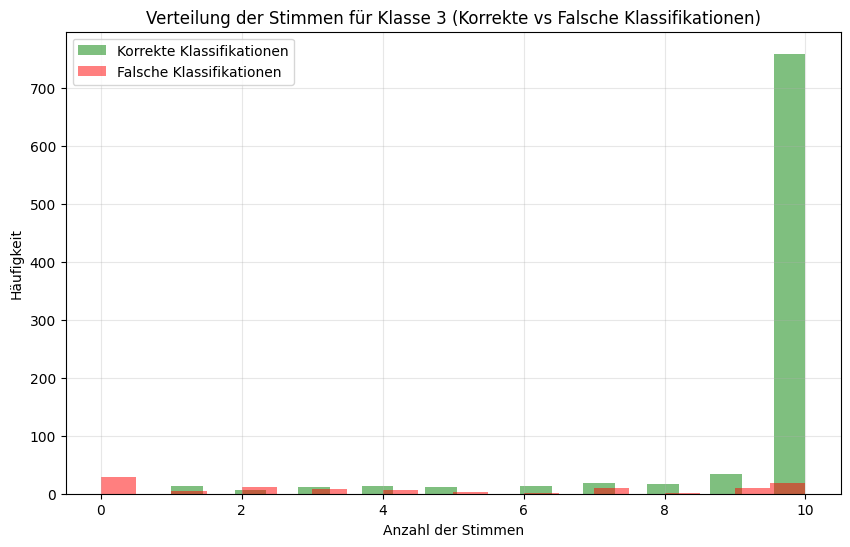

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.38
Durchschnittliche Stimmen für falsche Klassifikationen: 4.50


In [28]:
# Stimmen für Klasse 3 sammeln
correct_votes_3 = []
incorrect_votes_3 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])
    
    # Nur Klasse 3 berücksichtigen
    if correct_label == 3:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_3.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_3.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_3, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_3, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 3 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_3):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_3):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 4 (korrekte vs. falsche Klassifikationen)

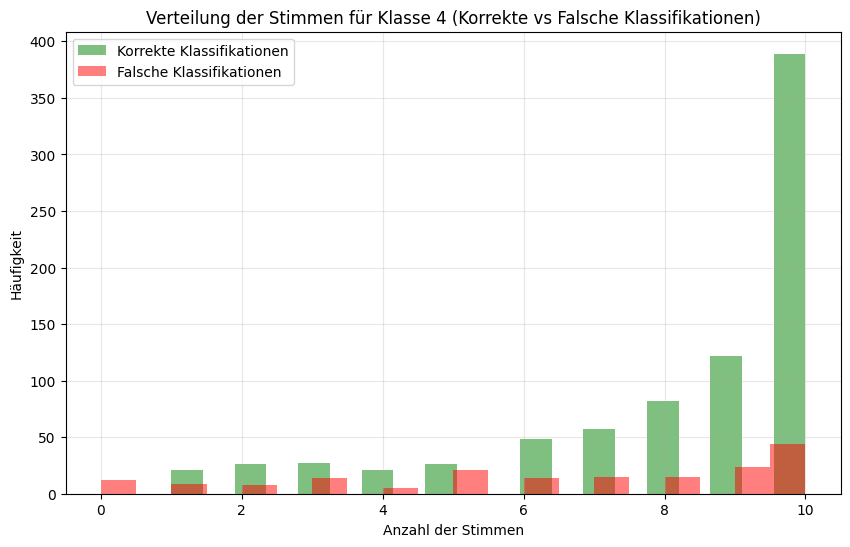

Durchschnittliche Stimmen für korrekte Klassifikationen: 8.18
Durchschnittliche Stimmen für falsche Klassifikationen: 6.39


In [17]:
# Stimmen für Klasse 4 sammeln
correct_votes_4 = []
incorrect_votes_4 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])
    
    # Nur Klasse 4 berücksichtigen
    if correct_label == 4:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_4.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_4.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_4, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_4, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 4 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_4):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_4):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 5 (korrekte vs. falsche Klassifikationen)

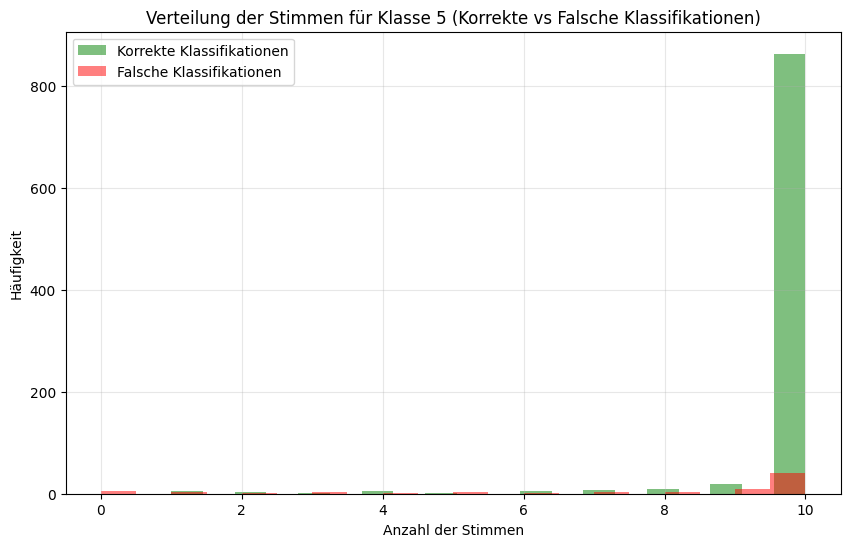

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.77
Durchschnittliche Stimmen für falsche Klassifikationen: 7.66


In [18]:
# Stimmen für Klasse 5 sammeln
correct_votes_5 = []
incorrect_votes_5 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])

    # Nur Klasse 5 berücksichtigen
    if correct_label == 5:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_5.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_5.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_5, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_5, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 5 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_5):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_5):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 6 (korrekte vs. falsche Klassifikationen)

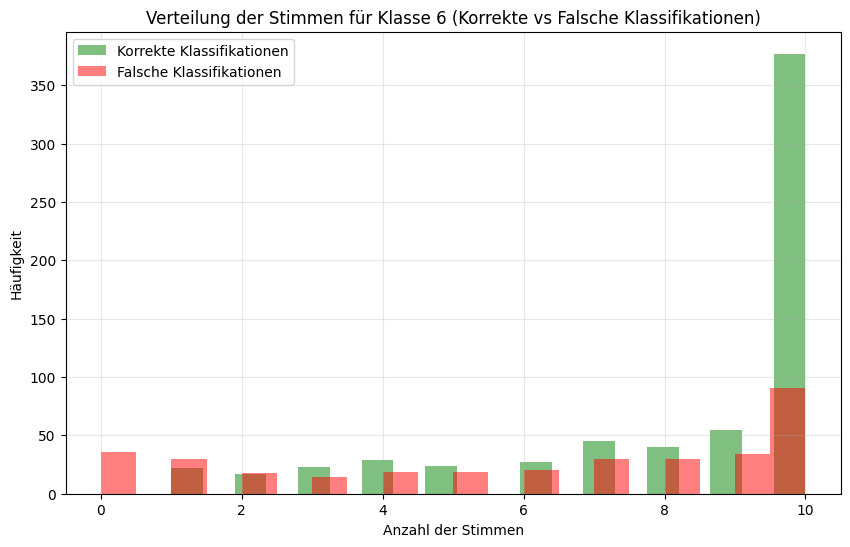

Durchschnittliche Stimmen für korrekte Klassifikationen: 8.23
Durchschnittliche Stimmen für falsche Klassifikationen: 6.06


In [19]:
# Stimmen für Klasse 6 sammeln
correct_votes_6 = []
incorrect_votes_6 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])

    # Nur Klasse 6 berücksichtigen
    if correct_label == 6:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_6.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_6.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_6, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_6, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 6 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_6):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_6):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 7 (korrekte vs. falsche Klassifikationen)

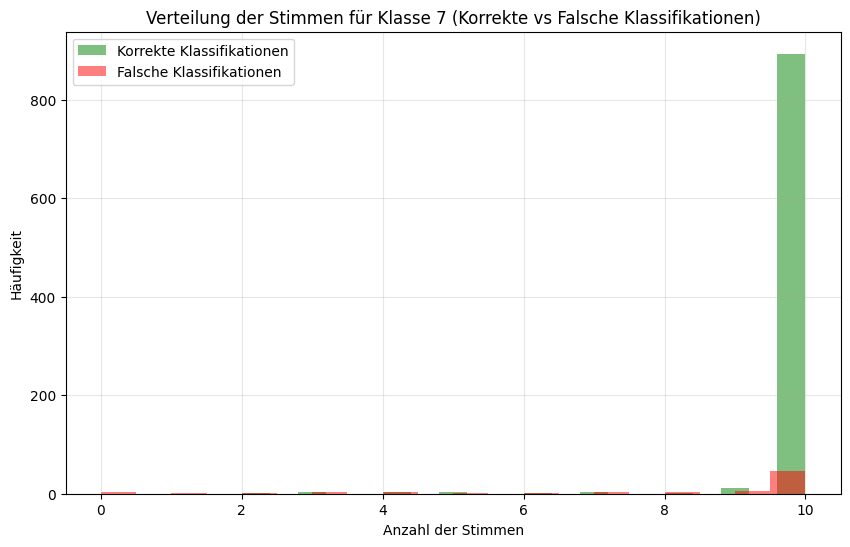

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.89
Durchschnittliche Stimmen für falsche Klassifikationen: 7.94


In [20]:
# Stimmen für Klasse 7 sammeln
correct_votes_7 = []
incorrect_votes_7 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])

    # Nur Klasse 7 berücksichtigen
    if correct_label == 7:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_7.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_7.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_7, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_7, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 7 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_7):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_7):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 8 (korrekte vs. falsche Klassifikationen)

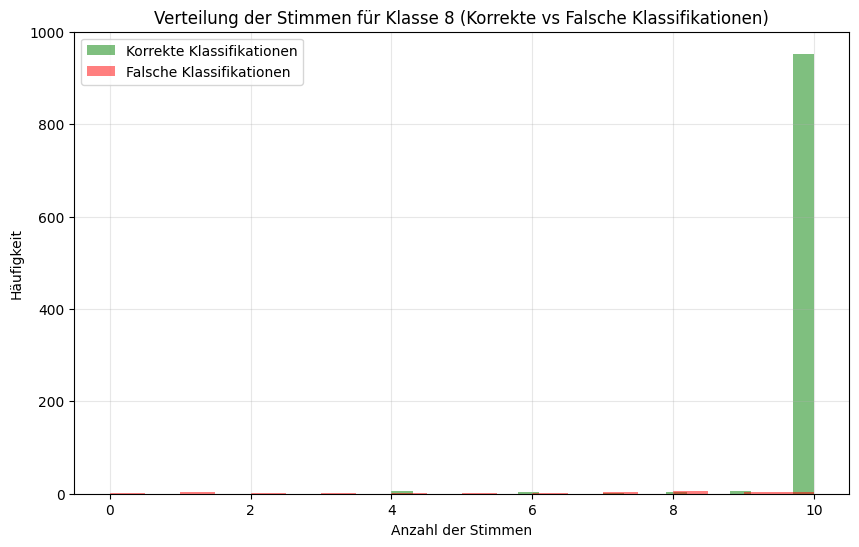

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.94
Durchschnittliche Stimmen für falsche Klassifikationen: 5.52


In [21]:
# Stimmen für Klasse 8 sammeln
correct_votes_8 = []
incorrect_votes_8 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])

    # Nur Klasse 8 berücksichtigen
    if correct_label == 8:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_8.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_8.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_8, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_8, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 8 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_8):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_8):.2f}')

#
Visualisierung der Stimmenverteilung für Klasse 9 (korrekte vs. falsche Klassifikationen)

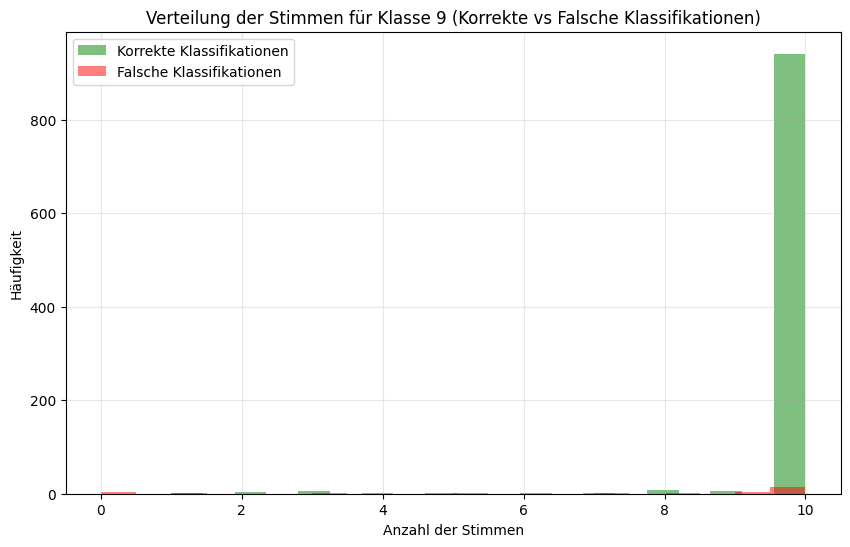

Durchschnittliche Stimmen für korrekte Klassifikationen: 9.87
Durchschnittliche Stimmen für falsche Klassifikationen: 7.61


In [22]:
# Stimmen für Klasse 9 sammeln
correct_votes_9 = []
incorrect_votes_9 = []

# Alle Testdaten durchgehen
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    correct_label = int(all_values[0])
    
    # Nur Klasse 9 berücksichtigen
    if correct_label == 9:
        if score == 1:  # Korrekte Klassifikation
            correct_votes_9.append(votes)
        else:  # Falsche Klassifikation
            incorrect_votes_9.append(votes)

# Diagramm erstellen
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_9, bins=20, alpha=0.5, label='Korrekte Klassifikationen', color='green')
plt.hist(incorrect_votes_9, bins=20, alpha=0.5, label='Falsche Klassifikationen', color='red')

plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Stimmen für Klasse 9 (Korrekte vs Falsche Klassifikationen)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistiken ausgeben
print(f'Durchschnittliche Stimmen für korrekte Klassifikationen: {numpy.mean(correct_votes_9):.2f}')
print(f'Durchschnittliche Stimmen für falsche Klassifikationen: {numpy.mean(incorrect_votes_9):.2f}')

#
### Visualisierung der Stimmenverteilung für alle Klassen (nur falsche Klassifikationen).

<Figure size 2000x1500 with 0 Axes>

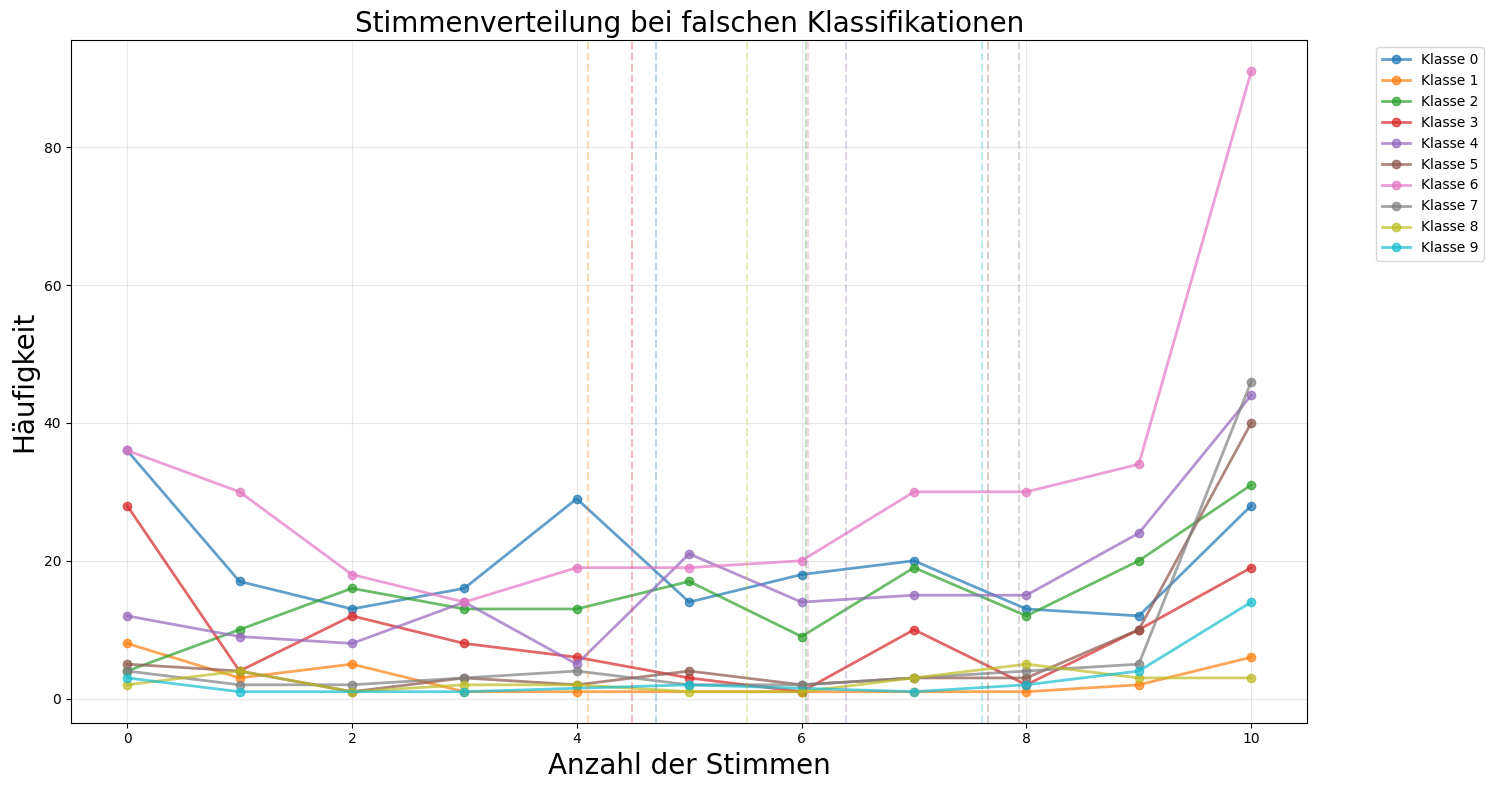


Statistiken (falsche Klassifikationen):
Klasse 0:
  Durchschnittliche Stimmen: 4.71
  Standardabweichung: 3.38
  Gesamtanzahl falsch klassifizierter Proben: 216

Klasse 1:
  Durchschnittliche Stimmen: 4.10
  Standardabweichung: 4.03
  Gesamtanzahl falsch klassifizierter Proben: 29

Klasse 2:
  Durchschnittliche Stimmen: 6.04
  Standardabweichung: 3.10
  Gesamtanzahl falsch klassifizierter Proben: 164

Klasse 3:
  Durchschnittliche Stimmen: 4.50
  Standardabweichung: 3.91
  Gesamtanzahl falsch klassifizierter Proben: 103

Klasse 4:
  Durchschnittliche Stimmen: 6.39
  Standardabweichung: 3.26
  Gesamtanzahl falsch klassifizierter Proben: 181

Klasse 5:
  Durchschnittliche Stimmen: 7.66
  Standardabweichung: 3.36
  Gesamtanzahl falsch klassifizierter Proben: 77

Klasse 6:
  Durchschnittliche Stimmen: 6.06
  Standardabweichung: 3.62
  Gesamtanzahl falsch klassifizierter Proben: 341

Klasse 7:
  Durchschnittliche Stimmen: 7.94
  Standardabweichung: 3.19
  Gesamtanzahl falsch klassifizierte

In [23]:
plt.figure(figsize=(20, 15))

# Daten für jede Klasse vorbereiten
classes = range(10)
class_votes_incorrect = [[] for _ in classes]

# Nur falsch klassifizierte Einträge sammeln
for record, votes, sc in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:
        continue
    correct_label = int(all_values[0])
    if sc == 0:  # 0 bedeutet falsche Klassifikation
        class_votes_incorrect[correct_label].append(votes)

# Liniendiagramm für alle Klassen (nur falsche Klassifikationen)
plt.figure(figsize=(15, 8))
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))

for i in classes:
    vote_counts = {}
    for vote in class_votes_incorrect[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1
    
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]
    
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )

plt.title('Stimmenverteilung bei falschen Klassifikationen', fontsize=20)
plt.xlabel('Anzahl der Stimmen', fontsize=20)
plt.ylabel('Häufigkeit', fontsize=20)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Mittlere Stimmenzahl pro Klasse als Linie einzeichnen
for i in classes:
    if class_votes_incorrect[i]:
        mean_votes = numpy.mean(class_votes_incorrect[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiken für jede Klasse
print("\nStatistiken (falsche Klassifikationen):")
for i in classes:
    if class_votes_incorrect[i]:
        mean_votes = numpy.mean(class_votes_incorrect[i])
        std_votes = numpy.std(class_votes_incorrect[i])
        print(f"Klasse {i}:")
        print(f"  Durchschnittliche Stimmen: {mean_votes:.2f}")
        print(f"  Standardabweichung: {std_votes:.2f}")
        print(f"  Gesamtanzahl falsch klassifizierter Proben: {len(class_votes_incorrect[i])}\n")
    else:
        print(f"Klasse {i}: Keine falsch klassifizierten Proben gefunden.\n")


#
### Visualisierung der Stimmenverteilung für alle Klassen (nur korrekte Klassifikationen).

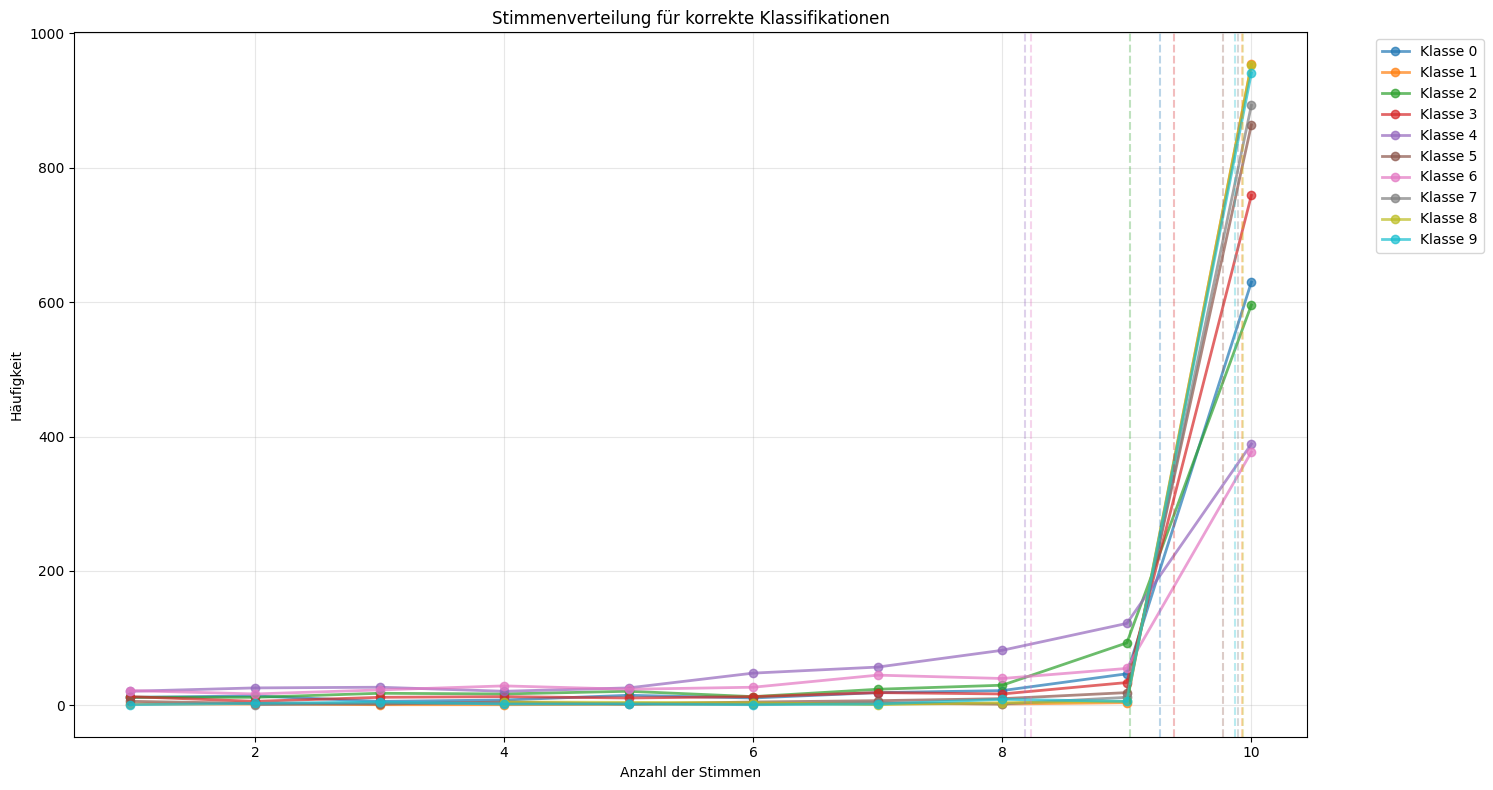


Stimmenstatistik (korrekte Klassifikationen):
Klasse 0:
  Durchschnittliche Stimmen: 9.26
  Standardabweichung: 1.92
  Gesamtanzahl richtig klassifizierter Proben: 784

Klasse 1:
  Durchschnittliche Stimmen: 9.93
  Standardabweichung: 0.67
  Gesamtanzahl richtig klassifizierter Proben: 971

Klasse 2:
  Durchschnittliche Stimmen: 9.03
  Standardabweichung: 2.08
  Gesamtanzahl richtig klassifizierter Proben: 836

Klasse 3:
  Durchschnittliche Stimmen: 9.38
  Standardabweichung: 1.80
  Gesamtanzahl richtig klassifizierter Proben: 897

Klasse 4:
  Durchschnittliche Stimmen: 8.18
  Standardabweichung: 2.50
  Gesamtanzahl richtig klassifizierter Proben: 819

Klasse 5:
  Durchschnittliche Stimmen: 9.77
  Standardabweichung: 1.12
  Gesamtanzahl richtig klassifizierter Proben: 923

Klasse 6:
  Durchschnittliche Stimmen: 8.23
  Standardabweichung: 2.65
  Gesamtanzahl richtig klassifizierter Proben: 659

Klasse 7:
  Durchschnittliche Stimmen: 9.89
  Standardabweichung: 0.71
  Gesamtanzahl richti

In [25]:
# Daten für jede Klasse vorbereiten
classes = range(10)
class_votes_correct = [[] for _ in classes]

# Stimmen nur für korrekt klassifizierte Einträge sammeln
for record, votes, sc in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:
        continue
    correct_label = int(all_values[0])
    if sc == 1:  # 1 bedeutet korrekte Klassifikation
        class_votes_correct[correct_label].append(votes)

# Liniendiagramm für alle Klassen (nur korrekte Klassifikationen) erstellen
plt.figure(figsize=(15, 8))
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))

for i in classes:
    vote_counts = {}
    for vote in class_votes_correct[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1
    
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]
    
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )

plt.title('Stimmenverteilung für korrekte Klassifikationen')
plt.xlabel('Anzahl der Stimmen')
plt.ylabel('Häufigkeit')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Mittellinien pro Klasse hinzufügen
for i in classes:
    if class_votes_correct[i]:
        mean_votes = numpy.mean(class_votes_correct[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiken für jede Klasse ausgeben
print("\nStimmenstatistik (korrekte Klassifikationen):")
for i in classes:
    if class_votes_correct[i]:
        mean_votes = numpy.mean(class_votes_correct[i])
        std_votes = numpy.std(class_votes_correct[i])
        print(f"Klasse {i}:")
        print(f"  Durchschnittliche Stimmen: {mean_votes:.2f}")
        print(f"  Standardabweichung: {std_votes:.2f}")
        print(f"  Gesamtanzahl richtig klassifizierter Proben: {len(class_votes_correct[i])}\n")
    else:
        print(f"Klasse {i}: Keine richtig klassifizierten Proben gefunden.\n")# Prepare data for each class


#
### Visualisierung der korrekten und falschen Klassifikationen pro Klasse.

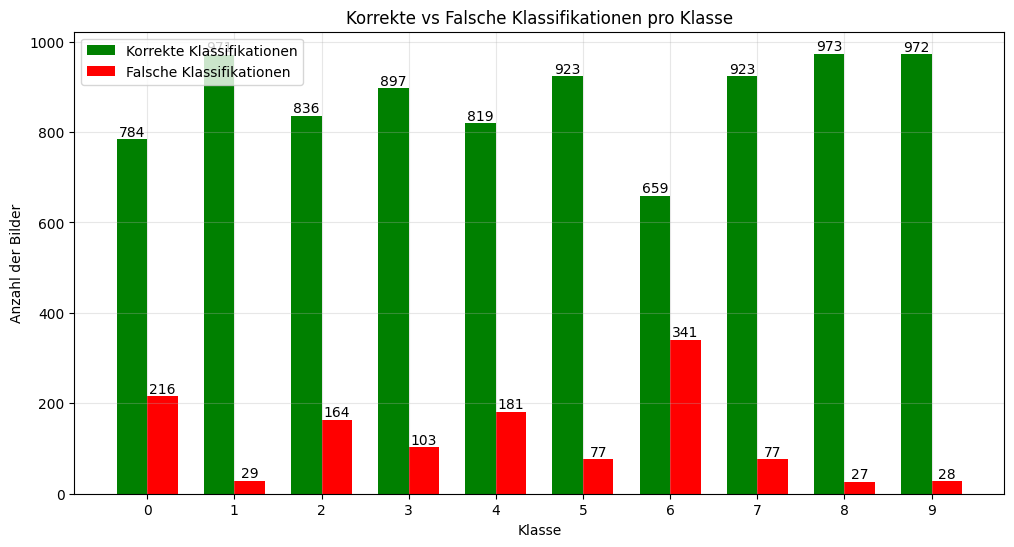


Genauigkeit pro Klasse:
Klasse 0: 78.40%
Klasse 1: 97.10%
Klasse 2: 83.60%
Klasse 3: 89.70%
Klasse 4: 81.90%
Klasse 5: 92.30%
Klasse 6: 65.90%
Klasse 7: 92.30%
Klasse 8: 97.30%
Klasse 9: 97.20%


In [26]:
# Calculate correct and incorrect classifications per class
class_results = {i: {'correct': 0, 'incorrect': 0} for i in range(10)}

# Go through all test data
for record, score in zip(test_data_list, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Ungültige Datensätze überspringen
        continue
        
    correct_label = int(all_values[0])
    if score == 1:
        class_results[correct_label]['correct'] += 1
    else:
        class_results[correct_label]['incorrect'] += 1

# Prepare data for plotting
classes = list(range(10))
correct_counts = [class_results[i]['correct'] for i in classes]
incorrect_counts = [class_results[i]['incorrect'] for i in classes]

# Create plot in German
plt.figure(figsize=(12, 6))
x = numpy.arange(len(classes))
width = 0.35

plt.bar(x - width/2, correct_counts, width, label='Korrekte Klassifikationen', color='green')
plt.bar(x + width/2, incorrect_counts, width, label='Falsche Klassifikationen', color='red')

plt.xlabel('Klasse')
plt.ylabel('Anzahl der Bilder')
plt.title('Korrekte vs Falsche Klassifikationen pro Klasse')
plt.xticks(x, classes)
plt.legend()

for i, v in enumerate(correct_counts):
    plt.text(i - width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(incorrect_counts):
    plt.text(i + width/2, v, str(v), ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.show()

# Print accuracy per class in German
print("\nGenauigkeit pro Klasse:")
for i in classes:
    total = class_results[i]['correct'] + class_results[i]['incorrect']
    accuracy = (class_results[i]['correct'] / total) * 100 if total > 0 else 0
    print(f"Klasse {i}: {accuracy:.2f}%")


#
### Diagramme für die Ausarbeitung erstellen.

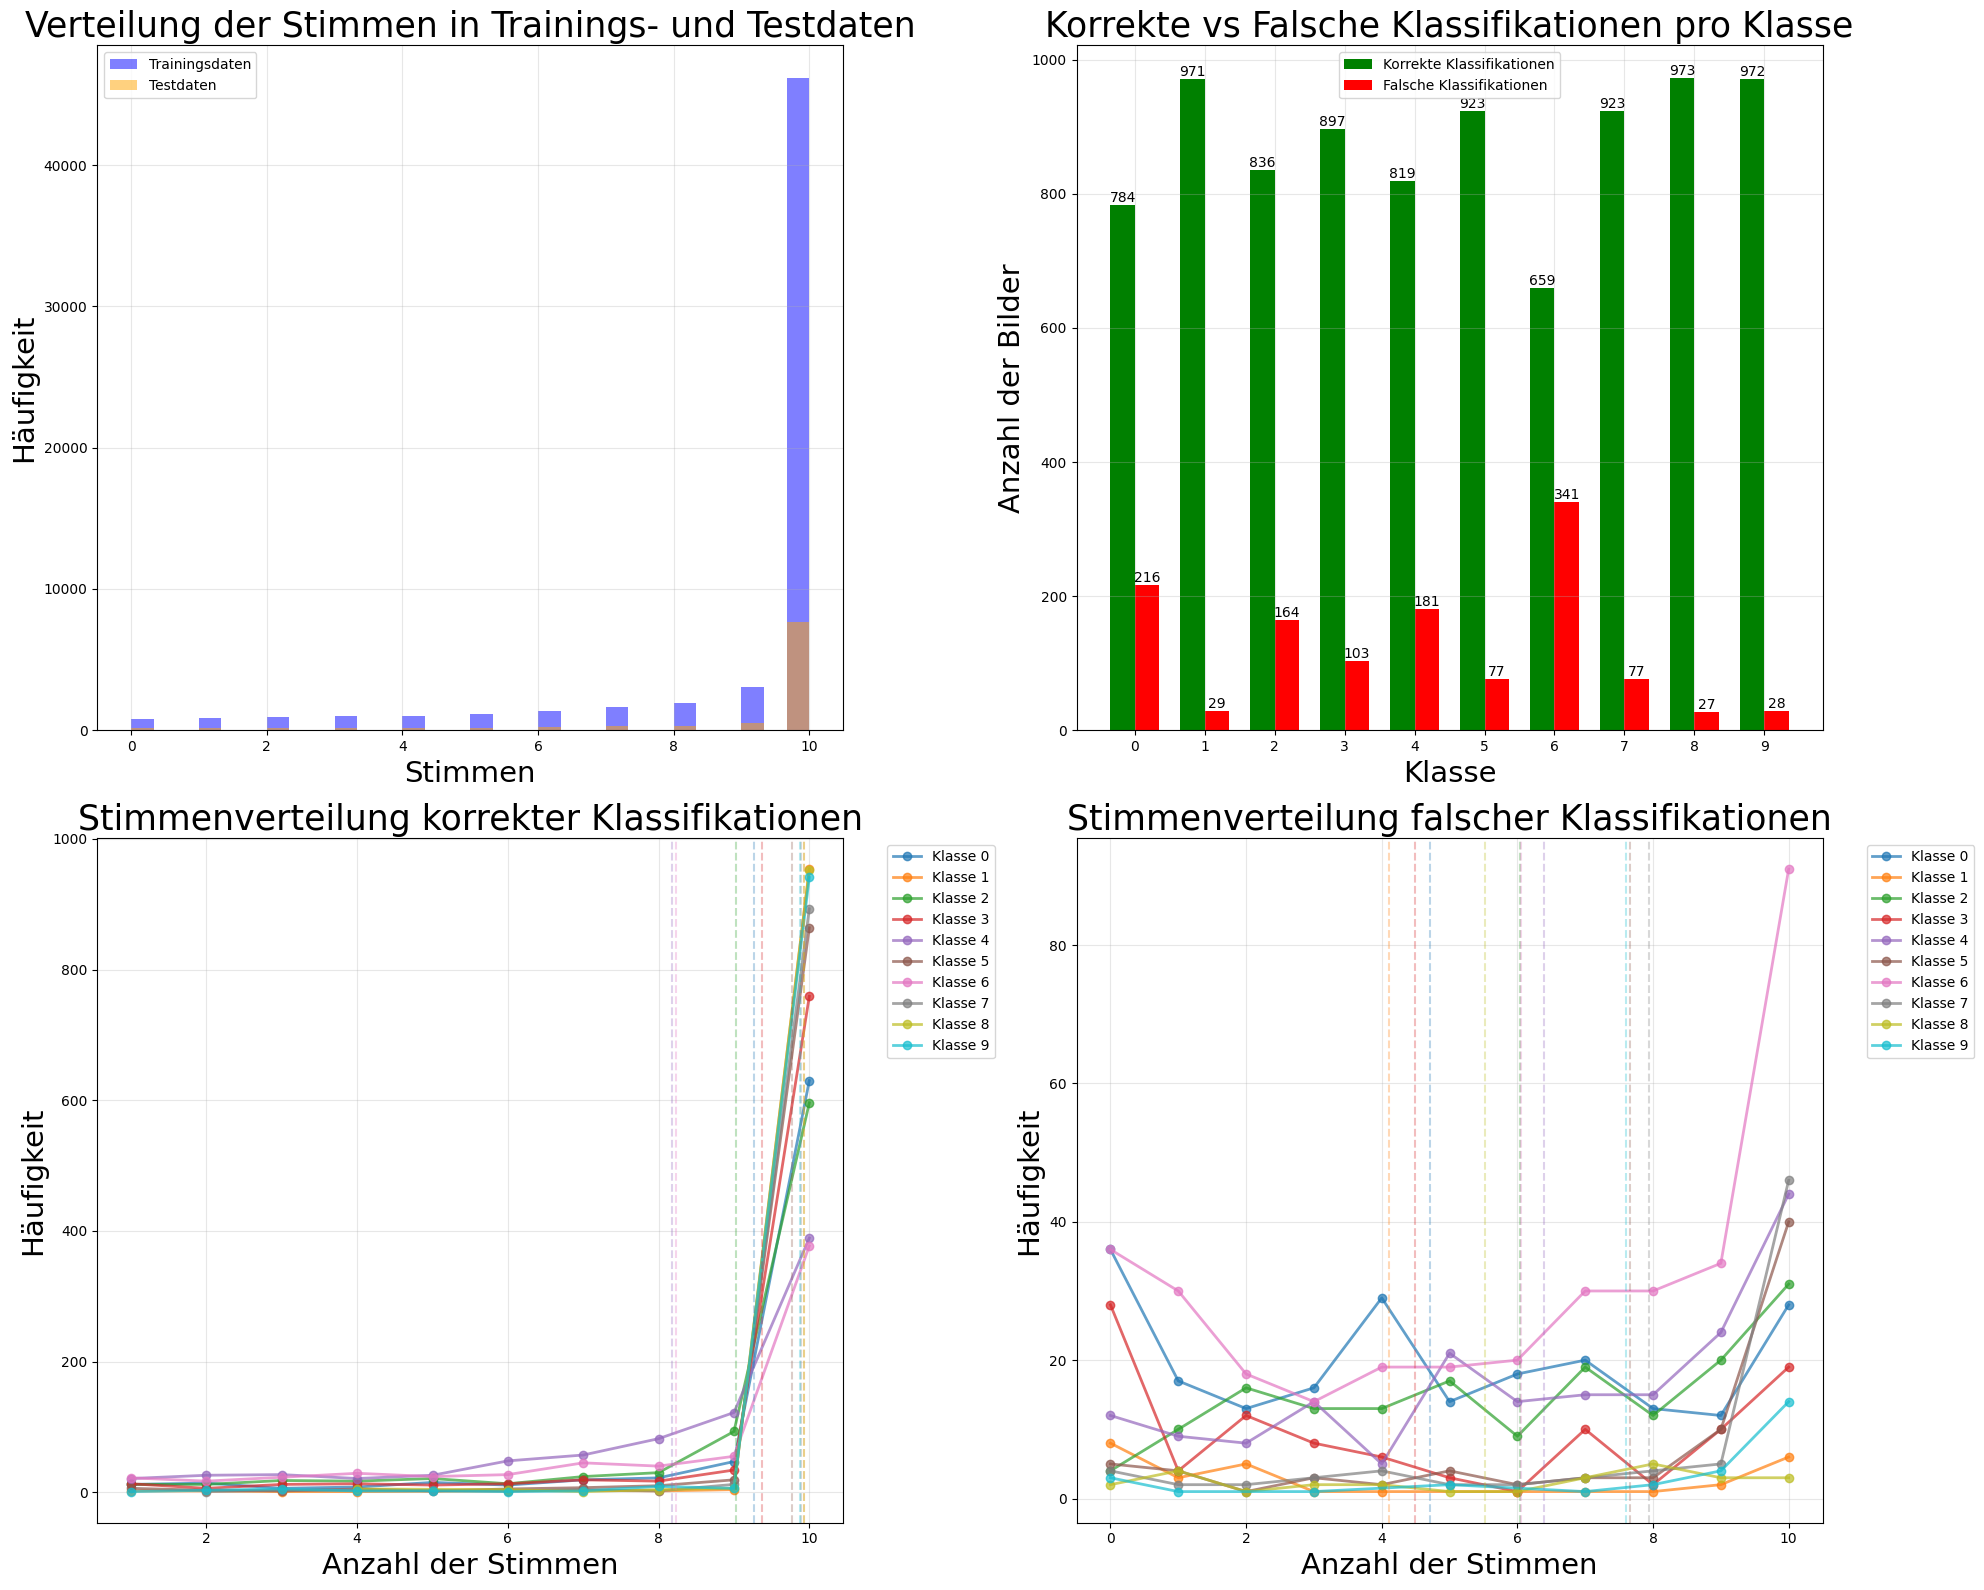

In [27]:
# Create a figure with 2x2 subplots
plt.figure(figsize=(20, 16))


plt.subplot(2, 2, 1)
plt.hist(train_vote_counts, bins=30, alpha=0.5, label='Trainingsdaten', color='blue')
plt.hist(test_vote_counts, bins=30, alpha=0.5, label='Testdaten', color='orange')
plt.xlabel('Stimmen', fontsize=21)
plt.ylabel('Häufigkeit', fontsize=21)
plt.title('Verteilung der Stimmen in Trainings- und Testdaten', fontsize=25)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
x = numpy.arange(len(classes))
width = 0.35
plt.bar(x - width/2, correct_counts, width, label='Korrekte Klassifikationen', color='green')
plt.bar(x + width/2, incorrect_counts, width, label='Falsche Klassifikationen', color='red')
plt.xlabel('Klasse', fontsize=21)
plt.ylabel('Anzahl der Bilder', fontsize=21)
plt.title('Korrekte vs Falsche Klassifikationen pro Klasse', fontsize=25)
plt.xticks(x, classes)
plt.legend()
for i, v in enumerate(correct_counts):
    plt.text(i - width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(incorrect_counts):
    plt.text(i + width/2, v, str(v), ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))
for i in classes:
    vote_counts = {}
    for vote in class_votes_correct[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1  
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]  
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )
plt.title('Stimmenverteilung korrekter Klassifikationen', fontsize=25)
plt.xlabel('Anzahl der Stimmen', fontsize=21)
plt.ylabel('Häufigkeit', fontsize=21)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i in classes:
    if class_votes_correct[i]:
        mean_votes = numpy.mean(class_votes_correct[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)
plt.tight_layout()

plt.subplot(2, 2, 4)
colors = plt.cm.tab10(numpy.linspace(0, 1, 10))
for i in classes:
    vote_counts = {}
    for vote in class_votes_incorrect[i]:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1
    votes_sorted = sorted(vote_counts.keys())
    frequencies = [vote_counts[v] for v in votes_sorted]
    plt.plot(
        votes_sorted, frequencies,
        '-', linewidth=2, marker='o',
        label=f'Klasse {i}', color=colors[i], alpha=0.7
    )
plt.title('Stimmenverteilung falscher Klassifikationen', fontsize=25)
plt.xlabel('Anzahl der Stimmen', fontsize=21)
plt.ylabel('Häufigkeit', fontsize=21)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i in classes:
    if class_votes_incorrect[i]:
        mean_votes = numpy.mean(class_votes_incorrect[i])
        plt.axvline(x=mean_votes, color=colors[i], linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()